# MidiNet用データの作成，前処理

用意するデータ
- bar (N, steps, pitch_range)
- bar_prev (N, steps, pitch_range)
- chord (N, 13) (0~12は主音，13は0: major, 1: minor)

chordのXMLデータはあるみたいだけど結局処理がめんどそうなのでchromaで判定した方が楽そう

処理の方針  
次の4つのタイプのデータを用意
- original: 論文に書かれているもの
- clipped: MIDI音程を128から64にシフトしたもの．メロディのシフトはそこから外れたもののみを使用
- headed: 音符の開始地点に，何ステップ伸びる音符であるかを記したもの
  
次のようなデータも扱いたいが，これらはモデルの改変が必要である
- head-conditioned: 音符の開始地点であるという情報を別のチャネルにしたもの
- diatonic: コードをルート音7つのみで表現したもの

## データ読込

In [1]:
import os, ipdb
import numpy as np
import pandas as pd
from pypianoroll import Multitrack, Track
from processors import SequentialProcessor, Processor
from utils import grid_plot, Timer

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = "../datasets/theorytab"
input_dir = f"{base_dir}/pianoroll"
input_csv = f"{base_dir}/theorytab.csv"
output_dir = f"{base_dir}/midinet"

In [3]:
df = pd.read_csv(input_csv)
print(df.shape)
df.head()

(39614, 19)


,Unnamed: 0,path,artist,song,part,nokey,key_signature,estimated_key_signature,in_scale_rate,estimated_in_scale_rate,highest,lowest,bpm,time_signature,beats,bars,time,has_melody_track,has_chord_track
0,0,q/quincy-jones-and-his-orchestra/soul-bossa-no...,quincy-jones-and-his-orchestra,soul-bossa-nova,chorus,False,Bb Major,Bb Major,0.88278,0.88278,73.0,65.0,146,4/4,48,12,19.73,True,True
1,1,q/quincy-jones-and-his-orchestra/soul-bossa-no...,quincy-jones-and-his-orchestra,soul-bossa-nova,chorus,True,Bb Major,C Major,0.74186,0.88278,63.0,55.0,146,4/4,48,12,19.73,True,True
2,2,q/queen-and-bowie/under-pressure/intro-and-ver...,queen-and-bowie,under-pressure,"intro,verse",False,D Major,D Major,1.00000,1.00000,73.0,57.0,120,4/4,32,8,16.00,True,True
3,3,q/queen-and-bowie/under-pressure/intro-and-ver...,queen-and-bowie,under-pressure,"intro,verse",True,D Major,C Major,0.74297,1.00000,71.0,55.0,120,4/4,32,8,16.00,True,True
4,4,q/queen-and-bowie/under-pressure/intro_nokey.mid,queen-and-bowie,under-pressure,intro,True,D Major,C Major,0.65812,1.00000,71.0,55.0,240,4/4,32,8,8.00,True,True


In [4]:
df = df[df["nokey"]][df["time_signature"] == "4/4"][df["has_melody_track"]][df["has_chord_track"]]
df = df.reset_index()
df.shape

/root/midinet-followup/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(16386, 20)

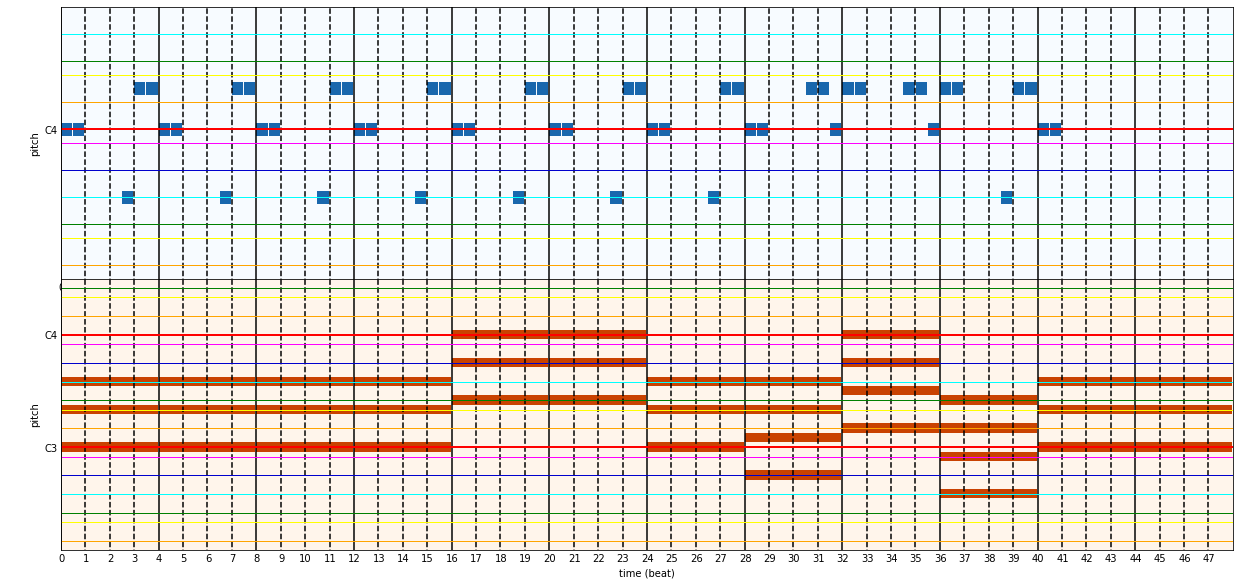

In [5]:
def get_sample():
    midi_path = os.path.join(input_dir, df['path'][0])
    ppr = Multitrack(midi_path)
    return ppr

grid_plot(get_sample())

## 処理フレームワーク
Processorを継承したクラスのインスタンスをPreprocessorへ与えてやることで前処理を行う  
ProcessorはリストでPypianorollProcessor.processへ渡され，pypianoroll.Multitrackとdataを順番に受け取っては処理していく  
最終的に得られたprocessed_melody(x, prev_x)とchordを合わせてnpzか何かで保存  
それを取り出してDatasetとして扱い，DataLoaderへ渡す腹積もり

In [6]:
class PypianorollProcessor(SequentialProcessor):
    """
    pypianoroll.Multitrackとその中で選択されたTrackに対して順次処理を行う
    """
    def __call__(self, ppr, tracks=None):
        if not isinstance(ppr, Multitrack): ppr = Multitrack(ppr)
        if tracks == None: tracks = list(range(len(ppr.tracks)))
        if not isinstance(tracks, list): tracks = [tracks]
        data = None
        for t in tracks:
            data = ppr.tracks[t]
            for processor in self.processors:
                ppr, data = processor(ppr, data)
        return ppr, data


def theorytab_preprocess(ppr, melody_processors=[], chord_processors=[]):
    """
    theorytabデータセットのデータに対し，メロディとコードへ指定の処理を行った結果を返す
    """
    ppr, processed_melody = PypianorollProcessor(melody_processors)(ppr, 0)
    ppr, processed_chord = PypianorollProcessor(chord_processors)(ppr, 1)
    return processed_melody, processed_chord

In [7]:
class TestProcessor(Processor):
    def __init__(self, number):
        self.number = number

    def __call__(self, ppr, data):
        print(f"test process {self.number}")
        return ppr, data

with Timer():
    ppr = get_sample()

with Timer():    
    melody, chord = theorytab_preprocess(ppr, TestProcessor(1), [TestProcessor(2), TestProcessor(3)])

0.006573
test process 1
test process 2
test process 3
0.000088


MIDIデータの読み込みに1/100secくらいかかるんだなぁ  
読込みだけで4分くらいかかるんだなぁ  
並列処理すればその限りではないけどなぁ

## 共通の前処理
- ベロシティは無視し，2値化する
- 最小ステップを16分音符にする
    - メロディのdown_resolutionするときの最初のステップにある音をそのステップの音とする
    - i.e. resolution: 24 -> 4なら，24 / 4 = 6ステップごとにある音をそのステップの音とする
    - 3連符や32分音符を取り除く
        - down_resolutionの過程で消える．(removeしていることにはなる．)
        - 3連符はつながっていればドレミ→ドドレミとなる
- メロディに音符のない小節は使用しない
- コードは，最初の12個を主音，最後をメジャーかマイナーの区別に使う．
    - 小節の最初のステップの和音を使い，1小節に1つのコードを割り当てる．
        - 分数コードや転回はないと踏む
        - コードトラックの小節の先頭で一番低い音をルートとする．
        - メジャーかマイナーかは次に低い音との距離で決定する．
- x:(bars, 16, 128), prev_x: (bars, 16, 128), chord: (bars, 13)のデータを得る
- 12個分のキーシフトを行うことでデータの水増しを行う
    - 上に11シフト

### ベロシティは無視し，2値化する

In [8]:
class Binalize(Processor):
    def __call__(self, ppr, track):
        ppr.binarize()
        track.binarize()
        return ppr, track

In [9]:
ppr = get_sample()
binalize = Binalize()

with Timer():
    ppr, track = binalize(ppr, ppr.tracks[0])
print(ppr.is_binarized(), track.is_binarized())

0.000133
True True


### resolutionを下げる

In [10]:
class DownBeatResolution(Processor):
    """
    全てのトラックのresolutionを下げるので注意
    """
    def __init__(self, resolution_to, resolution_from=None):
        self.res_to = resolution_to
        self.res_from = resolution_from
        
        if self.res_from is not None and self.res_to >= self.res_from:
            raise ValueError(f"Resolution_to (given: {self.res_to}) must be smaller than resolution_from (given: {self.res_from}).")
        
    def __call__(self, ppr, track):
        if self.res_from is None:
            if self.res_to >= ppr.beat_resolution:
                raise ValueError(f"Target resolution ({self.res_to}) must be smaller than the original resolution ({ppr.beat_resolution})")
            step_width = ppr.beat_resolution // self.res_to
        else:
            step_width = self.res_from // self.res_to
            
        ppr.beat_resolution = self.res_to
        ppr.downbeat = ppr.downbeat[::step_width]
        
        track_is_in_ppr = False
        for ppr_track in ppr.tracks:
            if ppr_track is track: track_is_in_ppr = True # isは参照の等価チェック
            ppr_track.pianoroll = ppr_track.pianoroll[::step_width]
        
        if not track_is_in_ppr:
            track.pianoroll = track.pianoroll[::step_width]
        
        return ppr, track

before -> resolution: 24, active length: 1151
0.000008
after: -> resolution: 4, active length: 192


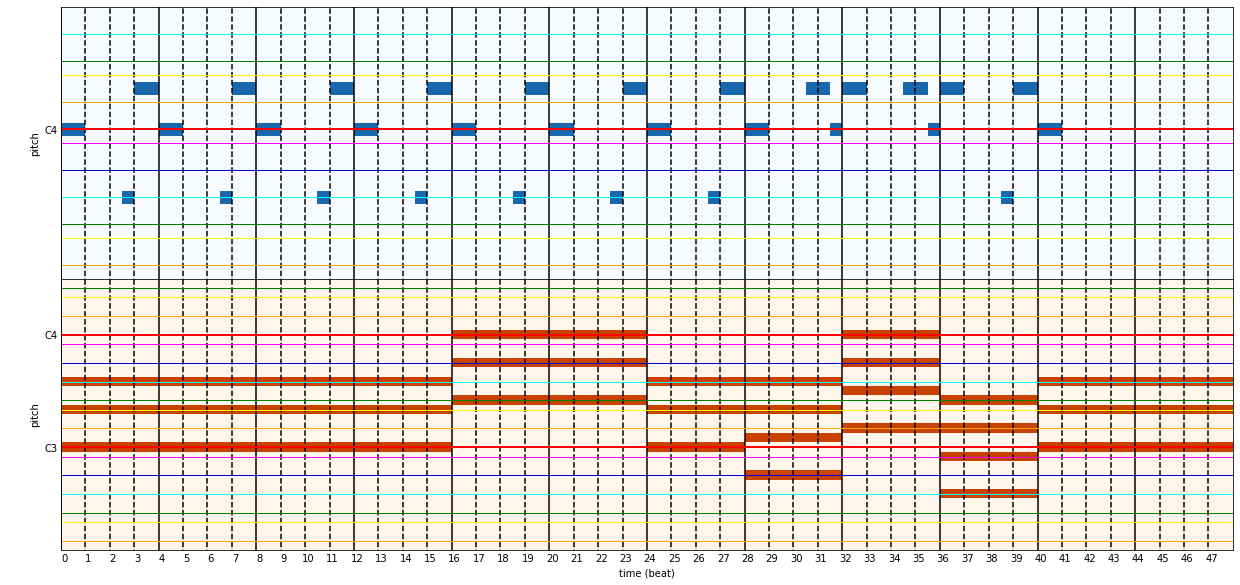

In [11]:
ppr = get_sample()
down_resolution = DownBeatResolution(4)

print(f"before -> resolution: {ppr.beat_resolution}, active length: {ppr.get_active_length()}")
with Timer():
    ppr, track = down_resolution(ppr, ppr.tracks[0])
print(f"after: -> resolution: {ppr.beat_resolution}, active length: {ppr.get_active_length()}")
grid_plot(ppr)

### メロディに音符のない小節は使用しない

In [12]:
class RemoveEmptyBars(Processor):
    def __init__(self, beats_in_bar=4):
        self.beats_in_bar = beats_in_bar
    
    def __call__(self, ppr, track):
        res = ppr.beat_resolution
        bar_res = self.beats_in_bar * res
        bars = int(np.ceil(len(ppr.downbeat) / bar_res))
        
        empty_steps = []
        for b in range(bars):
            if not track.pianoroll[b*bar_res:(b+1)*bar_res].any():
                empty_steps += list(range(b*bar_res, (b+1)*bar_res))
        
        ppr.downbeat = np.delete(ppr.downbeat, empty_steps)
        
        track_is_in_ppr = False
        for ppr_track in ppr.tracks:
            if ppr_track is track: track_is_in_ppr = True
            ppr_track.pianoroll = np.delete(ppr_track.pianoroll, empty_steps, axis=0)

        if not track_is_in_ppr:
            track.pianoroll = np.delete(track.pianoroll, empty_steps, axis=0)
                    
        return ppr, track

before -> active length: 1151
0.000798
after: -> active length: 1055


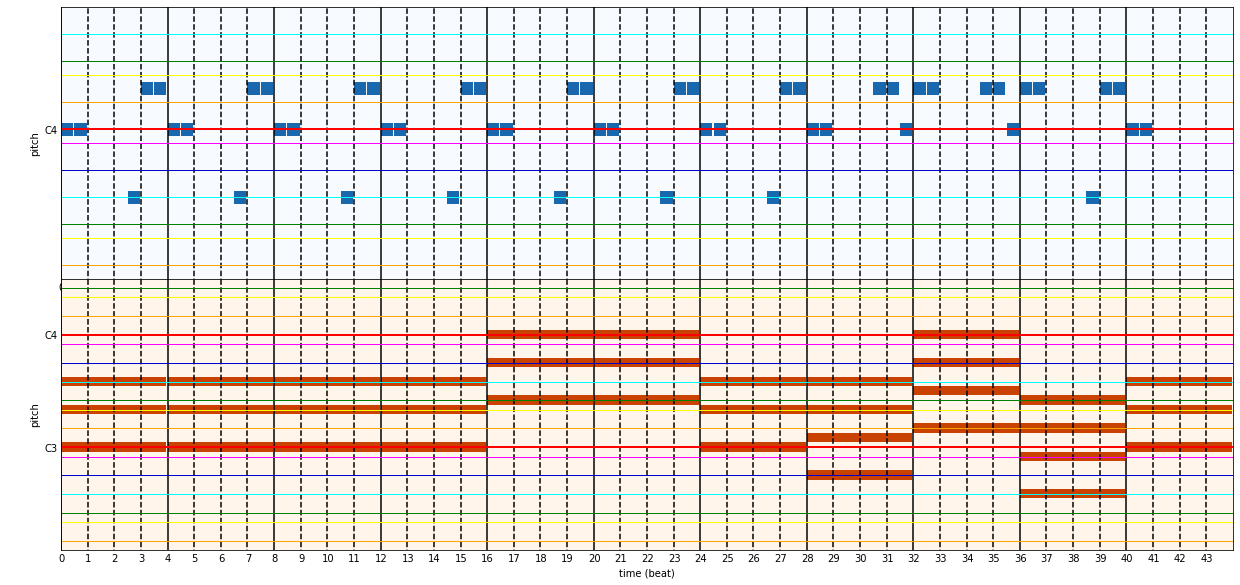

In [13]:
ppr = get_sample()
remove_empty_bars = RemoveEmptyBars()

print(f"before -> active length: {ppr.get_active_length()}")
with Timer():
    ppr, track = remove_empty_bars(ppr, ppr.tracks[0])
print(f"after: -> active length: {ppr.get_active_length()}")
grid_plot(ppr)

### コードベクトルの取得

In [14]:
class GetChordVectors(Processor):
    def __init__(self, minor=0, major=1, beats_in_bar=4):
        self.beats_in_bar = beats_in_bar
    
    def __call__(self, ppr, track):
        beat_res = ppr.beat_resolution
        bar_res = beat_res * self.beats_in_bar
        pianoroll = track.pianoroll
        
        chord_vecs = []
        for head in range(0, pianoroll.shape[0], bar_res):
            chord = np.where(pianoroll[head])[0]
            
            chord_vec = np.zeros(13)
            if len(chord) > 1:
                chord_vec[chord[0] % 12] = 1
                chord_vec[-1] = 0 if chord[1] - chord[0] == 3 else 1
            
            chord_vecs.append(chord_vec)
        
        return ppr, np.array(chord_vecs)

In [15]:
ppr = get_sample()
get_chord_vectors = GetChordVectors()

with Timer():
    ppr, chord_vecs = get_chord_vectors(ppr, ppr.tracks[1])
print(chord_vecs.shape)
for cv in chord_vecs:
    print(cv)

0.000085
(12, 13)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


### メロディを小節ごとに分割

In [16]:
class GetBars(Processor):
    def __init__(self, beats_in_bar=4):
        self.beats_in_bar = beats_in_bar
    
    def __call__(self, ppr, track):
        beat_res = ppr.beat_resolution
        bar_res = beat_res * self.beats_in_bar
        pianoroll = track.pianoroll
        
        bars = []
        for head in range(0, pianoroll.shape[0], bar_res):
            bars.append(pianoroll[head:head+bar_res])
        
        return ppr, np.array(bars)

bar resolution: 96
0.000697
(12, 96, 128)


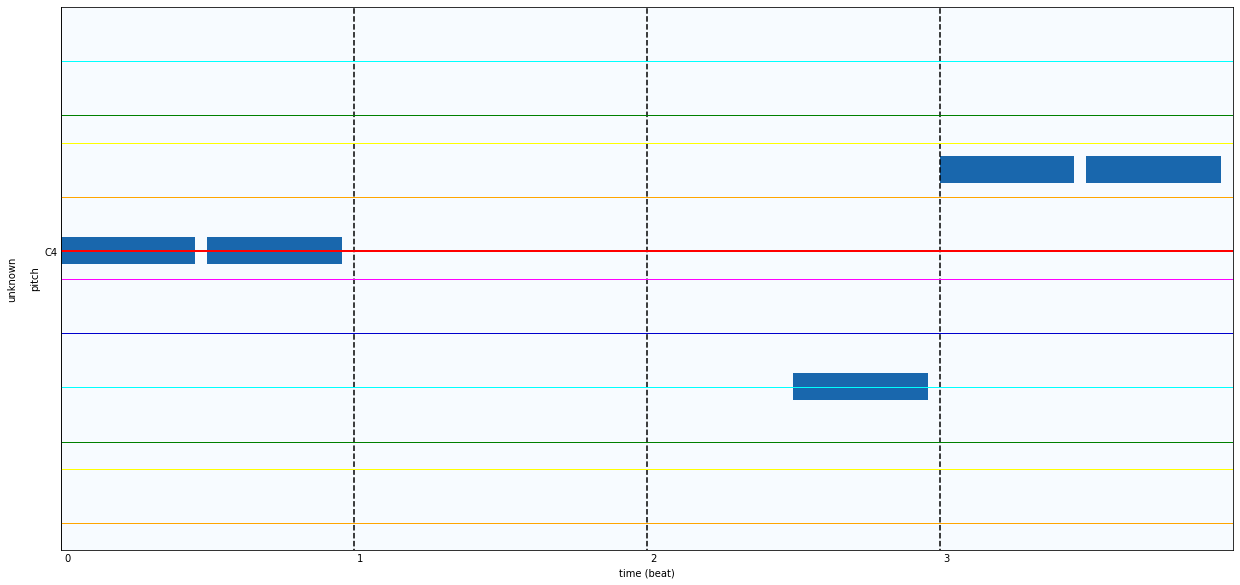

In [17]:
ppr = get_sample()
get_bars = GetBars()

print("bar resolution:", ppr.beat_resolution * 4)
with Timer():
    ppr, bars = get_bars(ppr, ppr.tracks[0])
print(bars.shape)
grid_plot(Track(pianoroll=bars[0]), beat_resolution=ppr.beat_resolution)

In [18]:
a = np.ones([10, 16, 128]) # bars, steps, pitches
result = a.tolist()
with Timer():
    s0, s1, s2 = a.shape
    a = a.T.tolist()
    empty = np.zeros([1,s1,s0]).tolist()
    for i in range(s2 - 1):
        a.pop(-1)
        a = empty + a
    a = np.array(a).T

# print(a)
print(a.shape)

0.003396
(10, 16, 128)


### キーシフトによるデータの水増し
- bars (bars, 16, 128) -> np.array(bars * 12, 16, 128)
- Track.pianoroll (length, 128) -> np.array(length * 12, 128)

配列からはどこからどこまでが1曲分なのかが分からないかもしれないが，1曲分の長さはpprから取得してもらうことにする．  
そうでなくても長さを12等分すればいい

In [19]:
class AugumentBars(Processor):
    def __init__(self, shifts=11, up=True):
        self.shifts = shifts
        self.keys = shifts + 1
        self.up = up
    
    def get_active_range(self, bars):
        lowest, highest = 0, 127
        while not np.any(bars[:, :, lowest]) and lowest <= 127: lowest += 1
        if lowest > highest: return None, None
        while not np.any(bars[:, :, highest]): highest -= 1
        return lowest, highest
    
    def __call__(self, ppr, bars):
        s0, s1, s2 = bars.shape
        augumented_bars = np.zeros([s0 * self.keys, s1, s2])
        lowest, highest = self.get_active_range(bars)
        if lowest and highest:
            clipped_bars = bars[:, :, lowest:highest+1]
            for s in range(self.keys):
                if self.up:
                    bottom, top = np.clip(lowest+s, 0, 127), np.clip(highest+s, 0, 127) + 1
                else:
                    bottom, top = np.clip(lowest-s, 0, 127), np.clip(highest-s, 0, 127) + 1
                augumented_bars[s0*s:s0*(s+1), :, bottom:top] = clipped_bars[:, :, 0:top-bottom]        
        return ppr, augumented_bars

input shape: (12, 96, 128)
0.007382
(144, 96, 128)


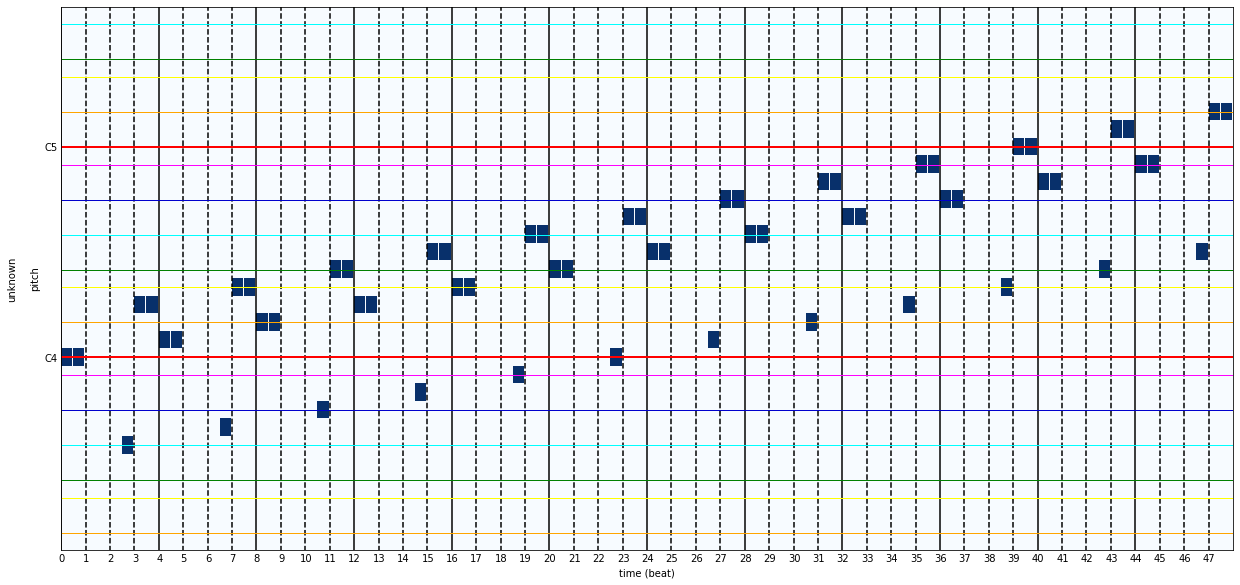

In [20]:
ppr = get_sample()
augument_bars = AugumentBars()

ppr, bars = get_bars(ppr, ppr.tracks[0])
print("input shape:", bars.shape)
with Timer():
    ppr, bars = augument_bars(ppr, bars)
print(bars.shape)
grid_plot(Track(pianoroll=np.vstack(bars[0::12])), beat_resolution=ppr.beat_resolution)

In [21]:
class AugumentTrack(Processor):
    def __init__(self, shifts=11, up=True):
        self.shifts = shifts
        self.keys = shifts + 1
        self.up = up
    
    def get_active_range(self, bars):
        lowest, highest = 0, 127
        while not np.any(bars[:, lowest]) and lowest <= 127: lowest += 1
        if lowest > highest: return None, None
        while not np.any(bars[:, highest]): highest -= 1
        return lowest, highest
    
    def __call__(self, ppr, track):
        bars = track.pianoroll if isinstance(track, Track) else track
        s0, s1 = bars.shape
        augumented_bars = np.zeros([s0 * self.keys, s1])
        lowest, highest = self.get_active_range(bars)
        if lowest and highest:
            clipped_bars = bars[:, lowest:highest+1]
            for s in range(self.keys):
                if self.up:
                    bottom, top = np.clip(lowest+s, 0, 127), np.clip(highest+s, 0, 127) + 1
                else:
                    bottom, top = np.clip(lowest-s, 0, 127), np.clip(highest-s, 0, 127) + 1
                augumented_bars[s0*s:s0*(s+1), bottom:top] = clipped_bars[:, 0:top-bottom]        
        return ppr, augumented_bars

input shape: (1152, 128)
0.008381
(13824, 128)


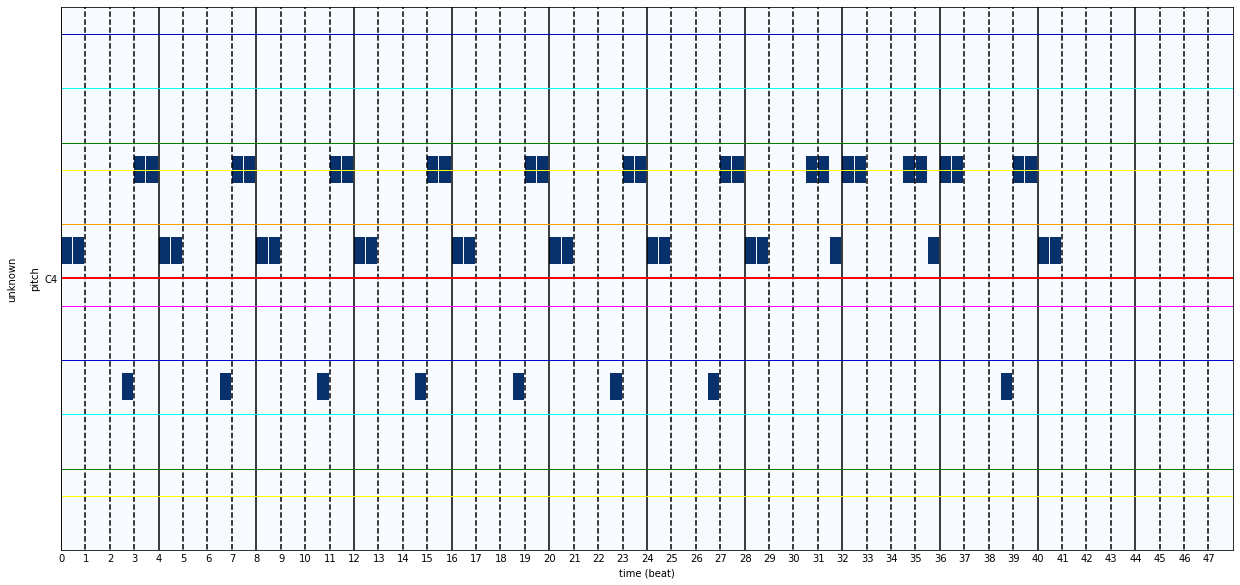

In [22]:
ppr = get_sample()
augument_track = AugumentTrack()

print("input shape:", ppr.tracks[0].pianoroll.shape)
with Timer():
    ppr, bars = augument_track(ppr, ppr.tracks[0])
print(bars.shape)
i = 1
grid_plot(Track(pianoroll=np.vstack(bars[1152*i:1152*(i+1)])), beat_resolution=ppr.beat_resolution)

In [23]:
class AugumentChordVecs(Processor):
    def __init__(self, shifts=11, up=True):
        self.shifts = shifts
        self.keys = shifts + 1
        self.up = up
    
    def __call__(self, ppr, chord_vecs):
        chord_num, vec_length = chord_vecs.shape
        augumented_cv = np.zeros([chord_num * self.keys, vec_length])
        augumented_cv[:chord_num, :] = chord_vecs
        chords, modes = chord_vecs[:, :-1], chord_vecs[:, -1:]
        
        for k in range(1, self.keys):
            augumented_cv[k*chord_num:(k+1)*chord_num, -1:] = modes
        
        one = np.array([1], dtype=chord_vecs.dtype)
        for bar, chord_vec in enumerate(chord_vecs):
            for chord, is_set in enumerate(chord_vec):
                if is_set:
                    for shift in range(1, self.keys):
                        step_to_be_set = shift * chord_num + bar
                        chord_to_be_set = (chord + (shift if self.up else - shift)) % 12
                        augumented_cv[step_to_be_set, chord_to_be_set] = one
                    break
        
        return ppr, augumented_cv

In [24]:
ppr = get_sample()
augument_cv = AugumentChordVecs()

with Timer():
    ppr, chord_vecs = get_chord_vectors(ppr, ppr.tracks[1])
    ppr, augumented_cv = augument_cv(ppr, chord_vecs)

print("input shape:", chord_vecs.shape)
print("output shape:", augumented_cv.shape)
cv_len = len(chord_vecs)
print()
print(augumented_cv[12:24])
print()
for i in range(int(augumented_cv.shape[0] / chord_vecs.shape[0])):
    chords_in_key = augumented_cv[i*cv_len:(i+1)*cv_len, :-1]
    print(np.where(chords_in_key)[1])

0.000245
input shape: (12, 13)
output shape: (144, 13)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[0 0 0 0 5 5 0 9 2 7 0 0]
[ 1  1  1  1  6  6  1 10  3  8  1  1]
[ 2  2  2  2  7  7  2 11  4  9  2  2]
[ 3  3  3  3  8  8  3  0  5 10  3  3]
[ 4  4  4  4  9  9  4  1  6 11  4  4]
[ 5  5  5  5 10 10  5  2  7  0  5  5]
[ 6  6  6  6 11 11  6  3  8  1  6  6]
[7 7 7 7 0 0 7 4 9 2 7 7]
[ 8  8  8  8  1  1  8  5 10  3  8  8]
[ 9  9  9  9  2  2  9  6 11  4  9  9]
[10 10 10 10  3  3 10  7  0  5 10 10]
[11 11 11 11  4  4 11  8  1  6 11 11]


### 前小節データを得る
水増ししたものに対応する．  
「シフト→前小節」のほうが「前小節→シフト」よりもコストが少ない．  
前小節を取得するのは配列範囲の選択でいいが，二倍になった小節をシフトするのはコストがかかる

In [25]:
class GetPrevBars(Processor):        
    def __call__(self, ppr, bars):
        bars_len, bar_res, pitch_num = bars.shape
        song_len = len(ppr.downbeat) // bar_res
        
        empty_bar = np.zeros([1, bar_res, pitch_num])
        prev_bars = np.vstack((empty_bar, bars[:-1]))
        prev_bars[::song_len] = empty_bar
        
        return ppr, prev_bars

0.002824


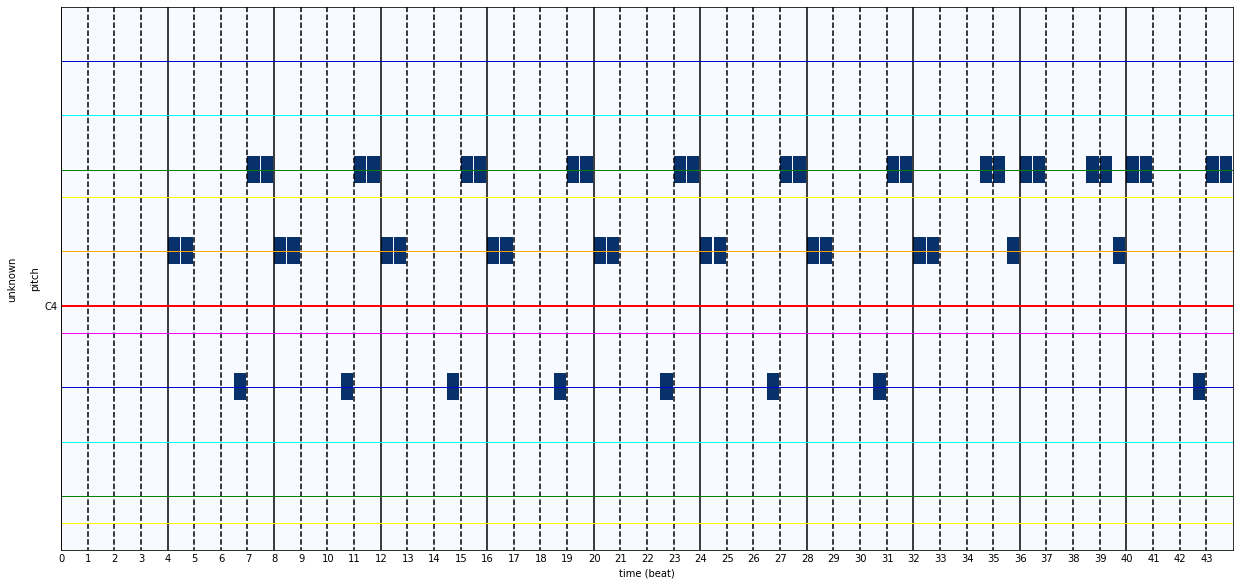

In [26]:
ppr = get_sample()
get_prev_bars = GetPrevBars()
melody = ppr.tracks[0]

for p in [remove_empty_bars, get_bars, augument_bars]:
    ppr, melody = p(ppr, melody)

with Timer():
    ppr, prev_bars = get_prev_bars(ppr, melody)
prev_bars.shape

i = 2
grid_plot(Track(pianoroll=np.vstack(prev_bars[i*11:(i+1)*11])), beat_resolution=ppr.beat_resolution)

In [27]:
class GetPrevTrack(Processor):
    def __init__(self, beats_in_bar=4):
        self.beats_in_bar = beats_in_bar
    
    def __call__(self, ppr, track):
        bars = track.pianoroll if isinstance(track, Track) else track
        steps, pitch_num = bars.shape
        bar_res = ppr.beat_resolution * self.beats_in_bar
        song_len = len(ppr.downbeat)
        augumented_num = steps // song_len
        
        empty_bar = np.zeros([bar_res, pitch_num])
        prev_bars = np.vstack((empty_bar, bars[:-bar_res]))
        
        for a in range(augumented_num):
            prev_bars[song_len*a:song_len*a+bar_res] = empty_bar
        
        return ppr, prev_bars

input shape: (1056, 128)
0.001723
output shape: (12672, 128)


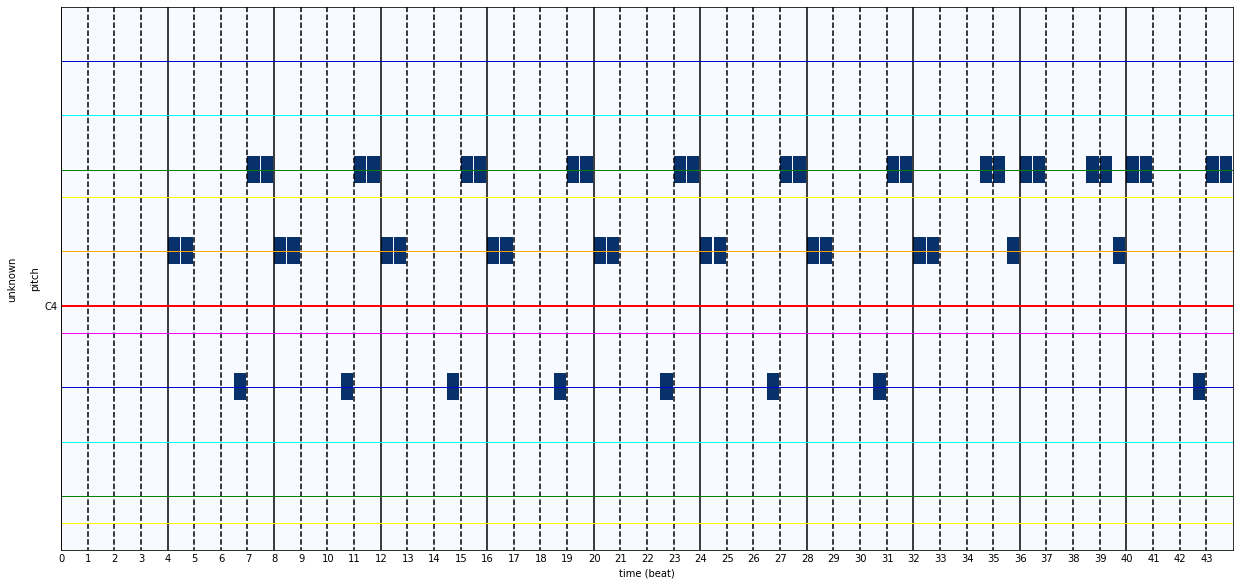

In [28]:
ppr = get_sample()
get_prev_track = GetPrevTrack()
melody = ppr.tracks[0]

for p in [remove_empty_bars, augument_track]:
    ppr, melody = p(ppr, melody)

print("input shape:", ppr.tracks[0].pianoroll.shape)
with Timer():
    ppr, prev_track = get_prev_track(ppr, melody)
print("output shape:", prev_track.shape)

i = 2
song_len = len(ppr.downbeat)
grid_plot(Track(pianoroll=np.vstack(prev_track[i*song_len:(i+1)*song_len])), beat_resolution=ppr.beat_resolution)

### 基本処理計測

start global processing
0.000271
0.000007
0.000314
start melody processing
0.000230
0.001377
start prev_melody processing
0.000414
start chord processing
0.000085
0.000218
melody shape: (132, 16, 128)
prev_melody shape: (132, 16, 128)
chord shape: (132, 13)
[0 0 0 0 5 5 0 9 2 7 0 0]
[ 1  1  1  1  6  6  1 10  3  8  1  1]
[ 2  2  2  2  7  7  2 11  4  9  2  2]
[ 3  3  3  3  8  8  3  0  5 10  3  3]
[ 4  4  4  4  9  9  4  1  6 11  4  4]
[ 5  5  5  5 10 10  5  2  7  0  5  5]
[ 6  6  6  6 11 11  6  3  8  1  6  6]
[7 7 7 7 0 0 7 4 9 2 7 7]
[ 8  8  8  8  1  1  8  5 10  3  8  8]
[ 9  9  9  9  2  2  9  6 11  4  9  9]
[10 10 10 10  3  3 10  7  0  5 10 10]
[11 11 11 11  4  4 11  8  1  6 11 11]


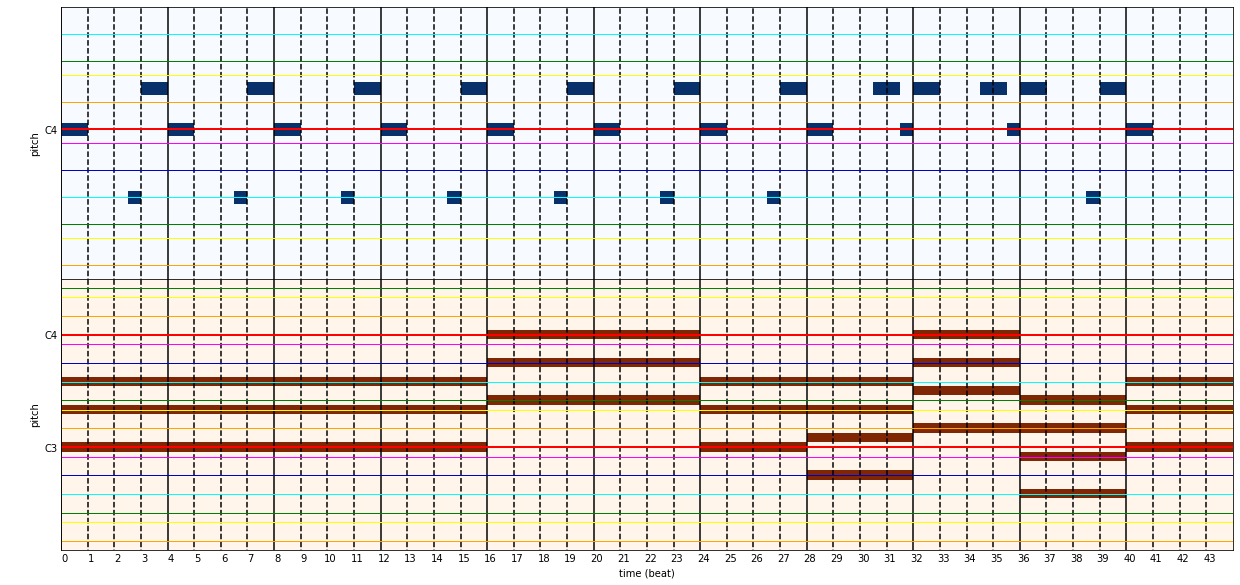

In [29]:
ppr = get_sample()
melody = ppr.tracks[0]

print("start global processing")
for p in [binalize, down_resolution, remove_empty_bars]:
    with Timer():
        ppr, melody = p(ppr, melody)

print("start melody processing")
for p in [get_bars, augument_bars]:
    with Timer():
        ppr, melody = p(ppr, melody)

print("start prev_melody processing")
with Timer():
    ppr, prev_melody = get_prev_bars(ppr, melody)

chord = ppr.tracks[1]
print("start chord processing")
for p in [get_chord_vectors, augument_cv]:
    with Timer():
        ppr, chord = p(ppr, chord)

print("melody shape:", melody.shape)
print("prev_melody shape:", prev_melody.shape)
print("chord shape:", chord.shape)
for i in range(12):
    chords_in_key = augumented_cv[i*cv_len:(i+1)*cv_len, :-1]
    print(np.where(chords_in_key)[1])
grid_plot(ppr)

## original
- トライアドコード以外のコードを含む楽譜を取り除く
- 休符をなくす
    - 休符が後ろについている場合は音符の長さをその分伸ばす
    - 小節の頭が休符の場合は2番目の音符を前に伸ばす
- メロディをC4～C5(C6?)までの2オクターブの中にシフト(でも128音使う．これによりモード崩壊しているかを判定できるらしい)

### トライアドコード以外のコードを含む楽譜を取り除く
global chord processingとしてmelody processingの前に入れる  
同じ小節に2つ以上のコードがある場合も取り除かれる  
1拍に高々1つのコードしか鳴っていないと仮定し，高速化  
さらに，コードトラックは48~84の3オクターブしか(基本)使っていないので範囲を制限して高速化

In [30]:
class RemoveNonTriadBars(Processor):
    def __init__(self, key=0, beats_in_bar=4, thresh=0, detect_per_beat=True, detect_pitch_range=[48,84]):
        self.key = key
        self.beats_in_bar = beats_in_bar
        self.thresh = thresh
        self.detect_per_beat = detect_per_beat
        self.detect_pitch_lowest, self.detect_pitch_highest = detect_pitch_range
        
        major_scale = [0, 2, 4, 5, 7, 9, 11]
        major_scale = [(pitch + key) % 12 for pitch in major_scale]
        self.major_scale = set(major_scale)
    
    def has_single_diatonic(self, nproll):
        # 小節内で使われている音程を取得
        chroma = set(np.where(nproll > self.thresh)[1]) # Bottle Neck
        
        # トライアドコードは1小節の中にちょうど3つの音程を持つ
        if len(chroma) != 3:
            return False

        # トライアドコードはすべての音程がkeyのメジャースケールに含まれる
        for pitch in chroma:
            if not pitch % 12 in self.major_scale:
                return False

        # トライアドコードのルートと第3和音の距離は3か4でなければならない
        p1, p3, p5 = chroma
        dist = p3 - p1
        if dist != 3 and dist != 4:
            return False
        
        return True
    
    def __call__(self, ppr, chord_track):
        res = ppr.beat_resolution
        detect_res = res if self.detect_per_beat else 1
        bottom, top = self.detect_pitch_lowest, self.detect_pitch_highest
        bar_res = self.beats_in_bar * res
        bars = int(np.ceil(len(ppr.downbeat) / bar_res))
        
        non_triad_steps = [] 
        for b in range(bars):
            left, right = b*bar_res, (b+1)*bar_res
            detect_area = chord_track.pianoroll[left:right:detect_res, bottom:top]
            if not self.has_single_diatonic(detect_area):
                non_triad_steps += list(range(left, right))
        
        ppr.downbeat = np.delete(ppr.downbeat, non_triad_steps)

        track_is_in_ppr = False
        for ppr_track in ppr.tracks:
            if ppr_track is chord_track: track_is_in_ppr = True
            ppr_track.pianoroll = np.delete(ppr_track.pianoroll, non_triad_steps, axis=0)

        if not track_is_in_ppr:
            chord_track.pianoroll = np.delete(chord_track.pianoroll, non_triad_steps, axis=0)

        return ppr, chord_track

start global melody processing
0.000323
0.000009
0.000595
start global chord processing
0.000666


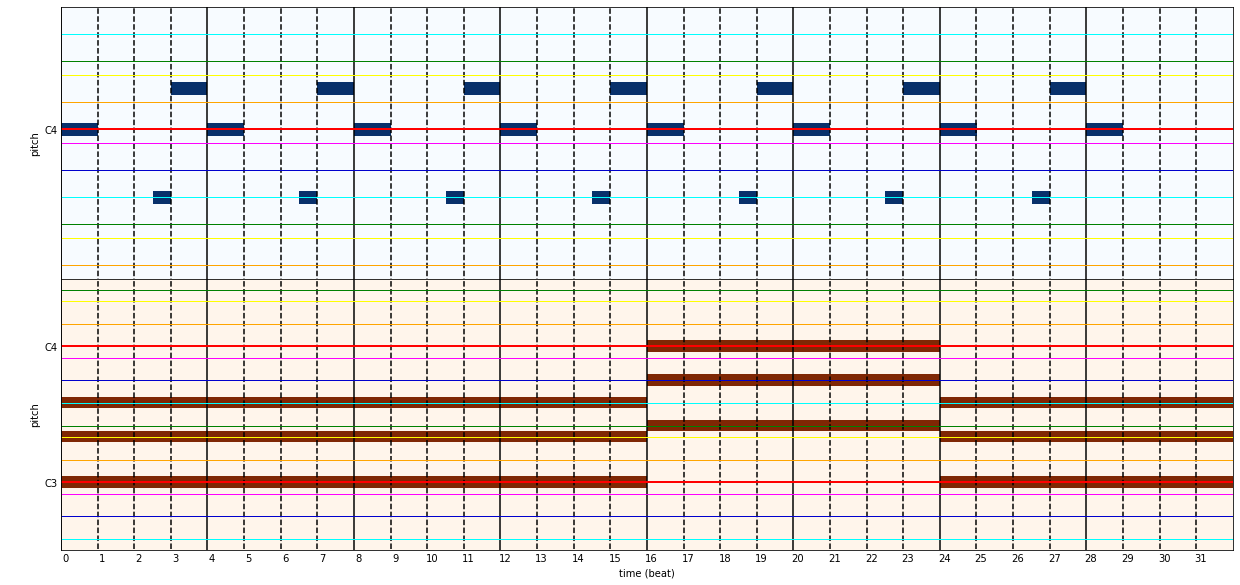

In [31]:
ppr = get_sample()
remove_non_triads = RemoveNonTriadBars()
melody = ppr.tracks[0]
chord_track = ppr.tracks[1]

print("start global melody processing")
for p in [binalize, down_resolution, remove_empty_bars]:
    with Timer():
        ppr, melody = p(ppr, melody)

print("start global chord processing")
with Timer():
    ppr, chord_track = remove_non_triads(ppr, chord_track)

grid_plot(ppr)

### メロディを2オクターブの中にシフト
melody processing
- active pitch rangeを求め，その中で作業を行う
- 指定されたbottomとtopの外側の範囲を求め，その中の音符を内側のオクターブへシフトする
    - top - bottom >= 12である必要がある
- 音符が被った場合は，より指定のレンジに近い音に上書きされる

ここに来てようやくわかったけど，pretty_midiのpitch=0はC-1でpypianorollのpitch=0はC-2だった

In [63]:
class ShiftInRange(Processor):
    def __init__(self, bottom, top):
        if bottom < 0 or top > 127:
            raise ValueError("Pitch range must be in [0, 127].")
        if top - bottom < 12:
            raise ValueError("Pitch range must be larger than 12 pitches.")
        self.bottom, self.top = bottom, top
        self.bottom_key, self.top_key = bottom % 12, top % 12
    
    def __call__(self, ppr, track):
        nproll = track.pianoroll if isinstance(track, Track) else track
        
        for b in range(0, bottom):
            notes = np.where(nproll[:, b])[0]
            if len(notes):
                nproll[notes, bottom + (b % 12 - self.bottom_key)] = nproll[notes, b]
        nproll[:, 0:bottom] = 0

        for t in range(127, top, -1):
            notes = np.where(nproll[:, t])[0]
            if len(notes):
                nproll[notes, top - (self.top_key - t % 12)] = nproll[notes, t]
        nproll[:, top+1:128] = 0
        
        return ppr, track

0.000834


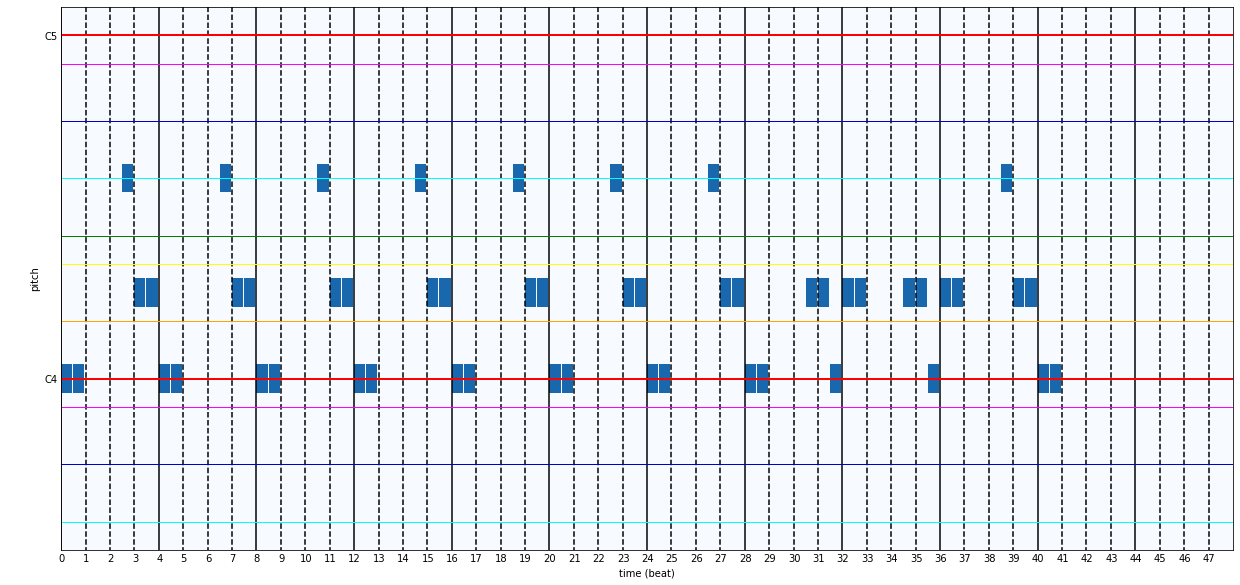

In [65]:
ppr = get_sample()
bottom, top = 60, 83 # C4 ~ B5
shift_in_range = ShiftInRange(bottom, top)
melody = ppr.tracks[0]

# print("start global melody processing")
# for p in [binalize, down_resolution, remove_empty_bars]:
#     ppr, melody = p(ppr, melody)

with Timer():
    ppr, melody = shift_in_range(ppr, melody)

grid_plot(melody, beat_resolution=ppr.beat_resolution)

### 休符をなくす
melody processing
- active pitch rangeを求め，その中で作業を行う
- 小節の頭が休符の場合は2番目の音符をそのまま伸ばす
    - 先頭から空白のステップがいくつあるかをanyで探す
    - 音符があるステップを見つけたらそれまでの空白のステップすべてにコピー
- 休符が後ろについている場合は音符の長さをその分伸ばす
    - 先頭埋め処理が終わった後に行う
    - 音符があるステップを求める
    - そこより先にある空白のステップ数をanyで求める
    - 求まった空白のステップ数分，今の音符の音程で埋める
    - その次のステップには音符があるので，そこから上記の処理を行うことを繰り返す

In [34]:
class RemoveRests(Processor):
    def __call__(self, ppr, track):
        return ppr, track